<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250709/%E5%89%B2%E5%BD%93%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###準備
20250709

In [1]:
%%capture
# python-mip ライブラリをインストールする
!pip install mip

# Matplotlibで日本語を表示するためのライブラリをインストール
!pip install japanize-matplotlib

# 必要なライブラリをインポートする
import mip
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import japanize_matplotlib # ← 日本語表示のためにインポート
import random

#割当問題

本講義では、
**割当問題 (Assignment Problem)**
について学びます。
この問題は、有限個の「エージェント（作業者、機械、リソースなど）」を、
同数の「タスク（仕事、役割、目的地など）」に1対1で割り当てる際に、
全体のコストを最小にする（あるいは全体の利益や効率を最大にする）最適な組み合わせを見つけ出すことを目的とします。

本講義の目標は以下の通りです。

1.  割当問題の基本的な概念、その重要性、および実社会での多様な応用例を理解する。
2.  割当問題を数理モデルとして定式化する手法を習得する。
3.  Pythonの最適化ライブラリ `python-mip` を用いて割当問題を実際に解く。
4.  割当問題の性質（輸送問題との関連、整数性など）や、代表的な解法（ハンガリー法など）について理解する。


##割当問題の定義

割当問題は、ある集合の要素（エージェント）を、別の集合の要素（タスク）に1対1に対応付ける問題である。
通常、エージェントの数とタスクの数は等しいと仮定される。
各エージェントが各タスクを実行する際には、
特定のコスト（または時間、非効率性など）が発生する
（あるいは、特定の利益や評価値が得られる）。
目的は、全てのタスクをエージェントに割り当て、
その際の総コストを最小にする（または総利益を最大にする）
ことである。

* **入力**:
  * $n$ 人のエージェントの集合
$A = \{A_1, A_2, \dots, A_n\}$
  * $n$ 個のタスクの集合
$T = \{T_1, T_2, \dots, T_n\}$
  * エージェント $A_i$ がタスク $T_j$ を実行した際のコスト（または効率の逆数など） $c_{ij}$

    これらはコスト行列
$$C = [c_{ij}]$$ として与えられる。
* **出力**:
    * 各エージェントをどのタスクに割り当てるかの1対1の対応付け。
* **目的**:
    * 割り当てられたペア $(A_i, T_j)$ のコスト $c_{ij}$ の総和を最小化する
    


### 簡単な例題と図解

3人の作業者（W1, W2, W3）と3つの仕事（J1, J2, J3）があり、各作業者が各仕事を行った場合のコスト（時間など）が以下の表で与えられているとする。

| 作業者/仕事 | J1 | J2 | J3 |
| :---------- | :-: | :-: | :-: |
| **W1** | 10 |  8  | 12 |
| **W2** |  7 | 11  |  9 |
| **W3** |  9 |  6  | 10 |

割当問題の目的は、
各作業者に異なる仕事を1つずつ割り当て、総コストを最小にすることである。


例えば、考えられる割り当ての1つとして、
* W1 $\to$ J1 (コスト10)
* W2 $\to$ J2 (コスト11)
* W3 $\to$ J3 (コスト10)

がある。
この割り当ての総コストは
$$10 + 11 + 10 = 31$$
である。また、別の割り当てとして、

* W1 $\to$ J2 (コスト8)
* W2 $\to$ J1 (コスト7)
* W3 $\to$ J3 (コスト10)

とすると、総コストは
$$8 + 7 + 10 = 25$$
となり、こちらの方が総コストが小さくなる。

割り当てを求める問題は、
以下のような
作業者（W1,W2,W3）と仕事（J1,J2,J3）をノードとした**二部グラフ**を考え、
各枝にはコストが付与されているとする。
その上で、
各ノードにちょうど1つだけ接続するよう枝を選び、
その枝のコストの総和を最も小さくする問題と考えることができる。
選んだ枝が、ノードとノードを結びつけることから、
マッチング（**matching**）と呼ばれる。

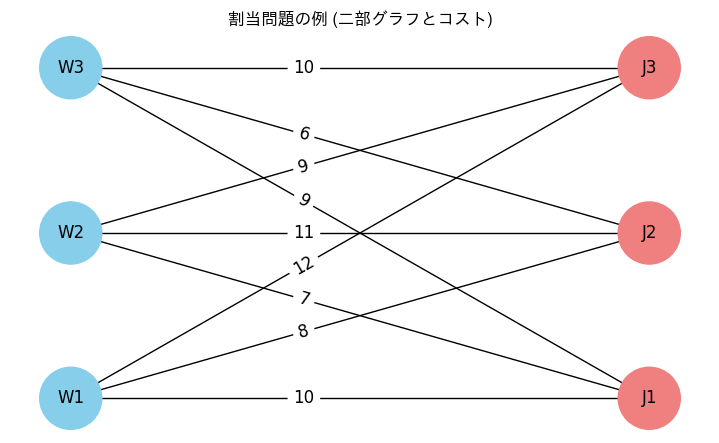

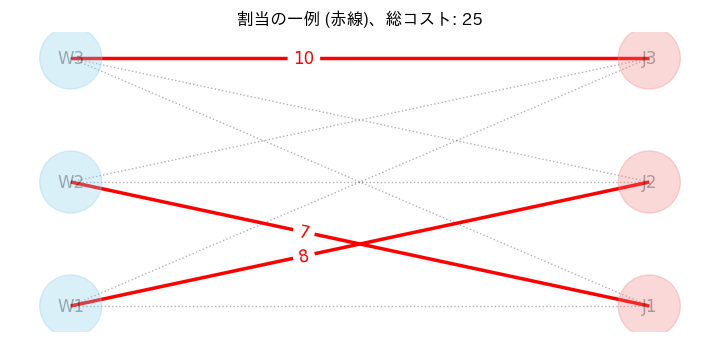

In [ ]:
#@title 二部グラフを使った図示
import networkx as nx
import matplotlib.pyplot as plt

# 例題データ
agents_ex_ap = ['W1', 'W2', 'W3']
tasks_ex_ap = ['J1', 'J2', 'J3']
costs_ex_ap_dict = {
    ('W1', 'J1'): 10, ('W1', 'J2'): 8,  ('W1', 'J3'): 12,
    ('W2', 'J1'): 7,  ('W2', 'J2'): 11, ('W2', 'J3'): 9,
    ('W3', 'J1'): 9,  ('W3', 'J2'): 6,  ('W3', 'J3'): 10,
}

# 二部グラフの作成
B_ex_ap = nx.Graph()
# エージェントノードを追加 (bipartite=0)
# タスクノードとの水平方向の距離を広げるために、エージェントのx座標を0、タスクのx座標を3とする
agent_x_coord = 0
task_x_coord = 3 # 以前は2だったものを3に変更

for i, agent in enumerate(agents_ex_ap):
    B_ex_ap.add_node(agent, bipartite=0, pos=(agent_x_coord, i))
# タスクノードを追加 (bipartite=1)
for i, task in enumerate(tasks_ex_ap):
    B_ex_ap.add_node(task, bipartite=1, pos=(task_x_coord, i))

# 辺 (可能な割り当てとコスト) を追加
for (agent, task), cost in costs_ex_ap_dict.items():
    B_ex_ap.add_edge(agent, task, weight=cost)

pos_ex_ap = nx.get_node_attributes(B_ex_ap, 'pos')
edge_labels_ex_ap = {(u,v): data['weight'] for u,v,data in B_ex_ap.edges(data=True)}

# 図示 (コスト表示)
plt.figure(figsize=(7, 4)) # 横幅を少し広げる
nx.draw(B_ex_ap, pos_ex_ap, with_labels=True, node_color=['skyblue' if B_ex_ap.nodes[node]['bipartite']==0 else 'lightcoral' for node in B_ex_ap.nodes()], node_size=2000)
nx.draw_networkx_edge_labels(B_ex_ap, pos_ex_ap, edge_labels=edge_labels_ex_ap, font_size=12, label_pos=0.4) # font_sizeを少し小さく、label_posを調整
plt.title("割当問題の例 (二部グラフとコスト)")
plt.show()

# 例の割り当て W1-J2, W2-J1, W3-J3 を表示
example_assignment_edges = [('W1','J2'), ('W2','J1'), ('W3','J3')]
example_assignment_cost = sum(costs_ex_ap_dict[edge] for edge in example_assignment_edges)

plt.figure(figsize=(7, 3)) # 横幅を少し広げる
nx.draw(B_ex_ap, pos_ex_ap, with_labels=True, node_color=['skyblue' if B_ex_ap.nodes[node]['bipartite']==0 else 'lightcoral' for node in B_ex_ap.nodes()], node_size=2000, style='dotted', alpha=0.3) # 背景は薄く
nx.draw_networkx_edges(B_ex_ap, pos_ex_ap, edgelist=example_assignment_edges, edge_color='red', width=2.5)
edge_labels_assigned = {edge: costs_ex_ap_dict[edge] for edge in example_assignment_edges}
nx.draw_networkx_edge_labels(B_ex_ap, pos_ex_ap, edge_labels=edge_labels_assigned, font_color='red', font_size=12, label_pos=0.4)
plt.title(f"割当の一例 (赤線)、総コスト: {example_assignment_cost}")
plt.show()

なお、
各ノードにちょうど1つだけ接続する枝が選ばれ
全てのノードが枝で結ばれた状態を**完全マッチング**
と呼び、
割当問題を二部グラフにおける**完全マッチング問題**
と呼ぶこともある。

もちろん、二部グラフでの完全マッチング問題では、
左右のノード数が等しいことを前提としている。
ノード数が異なれば実行可能解は存在しない。


## 実社会での応用例

割当問題は、リソースとタスクの最適なマッチングが求められる多くの場面で応用される。
選ばれた枝の総コストを最小化する場合だけでなく、
各枝に利益を付与した上で**利益の総和を最大化**
する場合も同様に割当問題と考えられる。

* **人事・労務管理**:
    * 作業員を特定の機械や工程に割り当てる。
    * 従業員をプロジェクトやシフトに割り当てる。
    * 新入社員を研修プログラムや部署に割り当てる。
* **プロジェクト管理**:
    * チームメンバーを特定のタスクや役割に割り当てる。
    * コンサルタントをクライアント案件に割り当てる。
* **スケジューリング**:
    * 航空機をフライトスケジュールに割り当てる（クルーの割り当てと合わせてより複雑な問題になる）。
    * 教室を授業に割り当てる。
    * 手術室を予定されている手術に割り当てる。
* **物流・輸送**:
    * トラックを配送ルートや集荷タスクに割り当てる（より複雑なVRPの一部として）。
    * タクシーを乗客の配車リクエストに割り当てる。
* **その他**:
    * コンピュータのプロセスをCPUコアに割り当てる。
    * 広告スロットを広告主に割り当てる。

これらの応用では、コスト、時間、スキル、優先度など、様々な評価基準が考慮される。

## 数理モデルによる定式化

割当問題を0-1整数計画問題として定式化する。
なお、以下では$n$をエージェント数（タスク数）とする。

### 決定変数

* $x_{ij}$: エージェント $i$ をタスク $j$ に割り当てる場合は $1$、そうでない場合は $0$ をとる（すなわち枝$(i,j)$を選ぶか選ばないかを示す）バイナリ変数。
($i = 0, \dots, n-1$; $j = 0, \dots, n-1$)

### パラメータ

* $n$: エージェントの数（およびタスクの数）。
* $c_{ij}$: エージェント $i$ がタスク $j$ を実行するのにかかるコスト（または時間、非効率性など）。

### 目的関数

割り当ての総コストを最小化する。

$$\min Z = \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} c_{ij} x_{ij}$$

もし利益 $p_{ij}$
を最大化したい場合は、目的関数は総利益の最大化となる。
$$
\max Z = \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} p_{ij} x_{ij}
$$
とする。

### 制約条件

1.  **エージェント割り当て制約**:
各エージェント $i$ は、正確に1つのタスクに割り当てられなければならない。
$$\sum_{j=0}^{n-1} x_{ij} = 1, \quad \forall i \in \{0, \dots, n-1\}$$

2.  **タスク割り当て制約**:
各タスク $j$ は、正確に1人のエージェントに割り当てられなければならない。
$$\sum_{i=0}^{n-1} x_{ij} = 1, \quad \forall j \in \{0, \dots, n-1\}$$

3.  **変数型制約**:
$$x_{ij} \in \{0, 1\}, \quad \forall i \in \{0, \dots, n-1\}, \forall j \in \{0, \dots, n-1\}$$

### 数理モデルのまとめ

**目的関数** (コスト最小化):
$$\min Z = \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} c_{ij} x_{ij}$$

**制約条件**:
1.  $\sum_{j=0}^{n-1} x_{ij} = 1 \quad \forall i \in \{0, \dots, n-1\}$  (各エージェントは1つのタスクへ)
2.  $\sum_{i=0}^{n-1} x_{ij} = 1 \quad \forall j \in \{0, \dots, n-1\}$  (各タスクは1人のエージェントから)
3.  $x_{ij} \in \{0, 1\} \quad \forall i, j \in \{0, \dots, n-1\}$

この定式化は、全ての供給量 $a_i$ と需要量 $b_j$ が1である
**バランス型輸送問題**
と全く同じ形をしている。

## Python MIP を用いた実装

`python-mip` ライブラリを用いて、上記の割当問題を解く。

### 問題データの設定 (上記例題データを使用)

In [ ]:
# エージェントとタスクの数
num_agents_ap = 3
num_tasks_ap = 3

# コスト行列 C[i,j]: エージェントiがタスクjを行うコスト
# W1, W2, W3 / J1, J2, J3
cost_matrix_ap = np.array([
    [10, 8, 12], # W1
    [7, 11, 9],  # W2
    [9, 6, 10]   # W3
])

agent_names_ap = [f"W{i+1}" for i in range(num_agents_ap)]
task_names_ap = [f"J{j+1}" for j in range(num_tasks_ap)]

print(f"{num_agents_ap}人のエージェントと{num_tasks_ap}個のタスク")
print("コスト行列:")
print(cost_matrix_ap)

3人のエージェントと3個のタスク
コスト行列:
[[10  8 12]
 [ 7 11  9]
 [ 9  6 10]]


### モデルの作成と変数の定義

In [ ]:
# 1. モデルの作成
model_ap = mip.Model(name="assignment_problem", sense=mip.MINIMIZE, solver_name=mip.CBC)

# インデックスの範囲
A_range = range(num_agents_ap)
T_range = range(num_tasks_ap)

# 2. 変数の定義
# x_ij: エージェントiをタスクjに割り当てるなら1
x_ap = {(i,j): model_ap.add_var(var_type=mip.BINARY, name=f"x_{i}_{j}")
        for i in A_range for j in T_range}

### 目的関数の設定

$$
\min Z = \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} c_{ij} x_{ij}
$$

In [ ]:
# 3. 目的関数の設定
model_ap.objective = mip.xsum(cost_matrix_ap[i,j] * x_ap[(i,j)]
                              for i in A_range for j in T_range)

### 制約条件の追加

$$
\sum_{j=0}^{n-1} x_{ij} = 1 \quad \forall i \in \{0, \dots, n-1\}
$$

$$
\sum_{i=0}^{n-1} x_{ij} = 1 \quad \forall j \in \{0, \dots, n-1\}
$$


In [ ]:
# 4. 制約条件の追加

# 制約1: 各エージェントiは、ちょうど1つのタスクjに割り当てられる
for i in A_range:
    model_ap += mip.xsum(x_ap[(i,j)] for j in T_range) == 1, f"agent_assign_constr_{i}"

# 制約2: 各タスクjは、ちょうど1人のエージェントiに割り当てられる
for j in T_range:
    model_ap += mip.xsum(x_ap[(i,j)] for i in A_range) == 1, f"task_assign_constr_{j}"

### 問題の求解と結果の表示・可視化

In [ ]:
#問題の求解
print("割当問題の最適化を開始します...")
status_ap = model_ap.optimize()

# 6. 結果の表示と可視化
if status_ap == mip.OptimizationStatus.OPTIMAL:
    print(f"最適解が見つかりました！")
    min_total_assignment_cost = model_ap.objective_value
    print(f"最小総割り当てコスト: {min_total_assignment_cost:.2f}")

    print("\n最適な割り当て:")
    assignments_sol_ap = []
    for i in A_range:
        for j in T_range:
            if x_ap[(i,j)].x >= 0.99: # x_ap[(i,j)] が1に近い
                print(f"  エージェント {agent_names_ap[i]} -> タスク {task_names_ap[j]} (コスト: {cost_matrix_ap[i,j]})")
                assignments_sol_ap.append((agent_names_ap[i], task_names_ap[j]))

elif status_ap == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能: 全てのエージェント/タスクを割り当てる解が存在しません。")
elif status_ap == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print(f"解が見つかりませんでした。")
else:
    print(f"最適化ステータス: {status_ap}")

割当問題の最適化を開始します...
最適解が見つかりました！
最小総割り当てコスト: 25.00

最適な割り当て:
  エージェント W1 -> タスク J2 (コスト: 8)
  エージェント W2 -> タスク J1 (コスト: 7)
  エージェント W3 -> タスク J3 (コスト: 10)


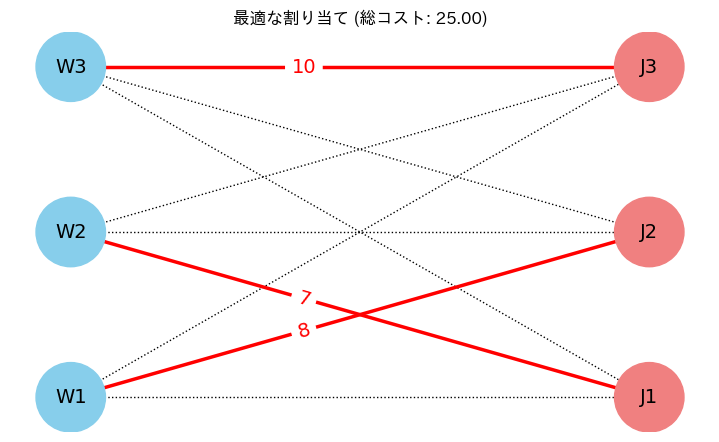

In [ ]:
#@title 結果の表示と可視化
G_ap_res = nx.Graph()

node_positions_ap = {}
agent_node_color = 'skyblue'
task_node_color = 'lightcoral'

# 水平方向の間隔を広げるため、タスクノードのx座標を大きくする
agent_x_vis = 0
task_x_vis = 4

for idx, ag_name in enumerate(agent_names_ap):
        G_ap_res.add_node(ag_name, bipartite=0)
        node_positions_ap[ag_name] = (agent_x_vis, idx)

for idx, ta_name in enumerate(task_names_ap):
        G_ap_res.add_node(ta_name, bipartite=1)
        node_positions_ap[ta_name] = (task_x_vis, idx)

all_possible_edges_ap = []
all_edge_labels_ap = {}
for i in A_range:
    for j in T_range:
        G_ap_res.add_edge(agent_names_ap[i], task_names_ap[j], weight=cost_matrix_ap[i,j])
        all_possible_edges_ap.append((agent_names_ap[i], task_names_ap[j]))
        all_edge_labels_ap[(agent_names_ap[i], task_names_ap[j])] = f"{cost_matrix_ap[i,j]}" # 文字列としてコストを格納

#plt.figure(figsize=(9, max(num_agents_ap,2) * 1.5 if num_agents_ap > 1 else 4)) # 横幅を広げ、縦幅を調整
plt.figure(figsize=(7, 4)) # 横幅を少し広げる

nx.draw(G_ap_res, node_positions_ap, with_labels=True,
            node_color=[agent_node_color if G_ap_res.nodes[n]['bipartite']==0 else task_node_color for n in G_ap_res.nodes()],
            node_size=2500, font_size=14, edgelist=all_possible_edges_ap, style=':', alpha=1)

assigned_edge_labels_ap = {(u,v): G_ap_res.edges[u,v]['weight'] for u,v in assignments_sol_ap}
nx.draw_networkx_edges(G_ap_res, node_positions_ap, edgelist=assignments_sol_ap, edge_color='red', width=2.5)
nx.draw_networkx_edge_labels(G_ap_res, node_positions_ap, edge_labels=assigned_edge_labels_ap, font_color='red', font_size=14, label_pos=0.4)

plt.title(f"最適な割り当て (総コスト: {min_total_assignment_cost:.2f})")
plt.axis('off') # 軸を非表示に
plt.show()

### 解法と性質

* **整数計画問題**:
割当問題は、決定変数 $x_{ij}$ が0または1の値を取るため、0-1整数計画問題として分類される。

* **輸送問題の特殊ケース**:
    割当問題は、全ての供給地の供給量が1であり、全ての需要地の需要量も1であるような、特殊なバランス型輸送問題と見なすことができる。このため、輸送問題の解法や性質の多くが割当問題にも適用できる。

* **完全ユニモジュラ性と整数性**:
    割当問題の制約行列は「完全ユニモジュラ (totally unimodular)」という特殊な性質を持つ。
    この性質により、線形計画緩和（$x_{ij}$ を $0 \le x_{ij} \le 1$ の連続変数として扱う）を解いても、最適解では自動的に全ての $x_{ij}$ が0または1の整数値を取ることが保証される。したがって、ソルバーで整数変数として明示的に指定しなくても整数解が得られる。

* **ハンガリー法 (Hungarian Algorithm)**:
    割当問題を解くための古典的で非常に効率的な専用アルゴリズムとして「ハンガリー法」が知られている。このアルゴリズムは、コスト行列を操作して0を増やし、0のみを使って割り当てを見つけるという手順に基づき、計算量は $O(n^3)$（$n$はエージェント/タスク数）である。MIPソルバーはより汎用的だが、純粋な（制約が少ない）大規模な割当問題に対しては、ハンガリー法の方が高速な場合がある。`scipy.optimize.linear_sum_assignment` で実装されている。

* **最大化問題への変換**:
    もし目的が利益や評価値の「最大化」である場合、いくつかの対処法がある。
    1.  目的関数を `sense=mip.MAXIMIZE` に変更する。
    2.  各利益 $p_{ij}$ の符号を反転させて $-p_{ij}$ とし、この総和を最小化する（これは $\sum p_{ij}x_{ij}$ を最大化することと等価）。

---
#演習問題



##**演習問題1**

3エージェント（A0, A1, A2）と
3タスク（T0, T1, T2）
の割当問題を以下のコスト行列で最適化し、
最小の総コストを解答せよ。

```
C = [[10,  8, 12],
     [ 7, 11,  9],
     [ 9,  4, 10]]
```

##**演習問題2**

エージェント数とタスク数を4に増やし、以下のコスト行列で割当問題を解け。
最小の総コストを解答せよ。

```
C = [[13,  8, 16, 18],
     [10, 15,  3, 12],
     [12,  9,  4,  6],
     [ 6, 11, 14,  7]]
```

##**演習問題3**

3人の営業担当者（S1, S2, S3）と3つの地域（R1, R2, R3）があり、各担当者が各地域を担当した場合に期待される利益が以下の表で与えられている。
総利益を最大にする割り当てを求め、総利益の最大値を解答せよ。

| 担当者/地域 | R1 | R2 | R3 |
| :---------- | :-: | :-: | :-: |
| **S1** | 50 | 65 | 70 |
| **S2** | 80 | 75 | 60 |
| **S3** | 55 | 60 | 75 |

考え方：目的関数を最大化にして解く。


##**演習問題4**

演習問題2で、エージェントを A0, A1, A2, A3、
タスクを T0, T1, T2, T3 とする。
A1がT2を担当できない
という制約を追加して、最適な割り当てを求め、
総コストの最小値を解答せよ。

##**演習問題5**

3人のエージェントと4つのタスクがあるとする。各エージェントは1つのタスクを担当し、各タスクは高々1人のエージェントに担当される（つまり、タスクのうち1つは担当されない）。
割り当てられたタスクの総コストの最小値を解答せよ。ただし、
コスト行列（3x4）は以下とする。
```
C = [[8, 2, 5, 7],
     [6, 4, 3, 9],
     [5, 7, 8, 4]]
```

##**演習問題6**

4人のエージェント(A0,A1,A2,A3)と4つのタスク(T0,T1,T2,T3)がある。コストは演習問題2の行列を使用する。
制約として
「もしエージェントA0がタスクT1に割り当てられたら、
エージェントA1はタスクT3に割り当てられなければならない」
を追加して最適化し、
総コストの最小値を求めよ。
